# Looking for traffic correlations
The goal of this analysis is to determine a few indicators of heavy traffic on Interstate highway #94. These indicators can be weather type, time of the day, time of the week, etc.

## 1. Data preparation
In this step we will import the data, examine it and refine for furter analytics.

### 1.1 Importing the data and necessary python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

traffic_volume_database = pd.read_csv('Metro_Interstate_Traffic_Volume.csv') # data download from https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume

Also reviewing the data

In [2]:
traffic_volume_database.info()
traffic_volume_database.head()
#traffic_volume_database.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### 1.2 Preparing all data for numerical analysis

Extracting time data

In [3]:
#traffic_volume_database.date_time.describe()
traffic_volume_database['date_time'] = pd.to_datetime(traffic_volume_database['date_time'])
traffic_volume_database['hour'] = traffic_volume_database['date_time'].dt.hour
traffic_volume_database['if_day'] = traffic_volume_database['date_time'].dt.hour.apply(lambda x: 1 if x > 6 and x < 23 else 0)
traffic_volume_database['day_of_the_week'] = traffic_volume_database['date_time'].dt.weekday # 0=Monday
traffic_volume_database['if_weekend'] = traffic_volume_database['date_time'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

Preparing holiday variable for numerical analysis

In [4]:
#traffic_volume_database.holiday.describe()
traffic_volume_database['if_holiday'] = traffic_volume_database['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

Preparing weather data for numerical analysis

In [5]:
#traffic_volume_database.weather_main.describe()
traffic_volume_database['weather_main_code'], weather_main_labels = pd.factorize(traffic_volume_database['weather_main'])
weather_main_legend = dict(enumerate(weather_main_labels))

'''
print("Legend for weather_main > weather_main_code variable:")
for code, label in weather_main_legend.items():
    print(f"{code}: {label}")
traffic_volume_database.weather_main_code.value_counts()
'''

weather_main_counts = traffic_volume_database['weather_main_code'].value_counts().sort_index()
weather_main_summary = pd.DataFrame({
    'code': weather_main_counts.index,
    'label': [weather_main_legend[i] for i in weather_main_counts.index],
    'count': weather_main_counts.values,
    '% of all': (weather_main_counts.values / weather_main_counts.sum() * 100).round(2)
}).sort_values(by='% of all', ascending=False)
from IPython.display import HTML
HTML(weather_main_summary.head().to_html(index=False))

code,label,count,% of all
0,Clouds,15164,31.46
1,Clear,13391,27.78
4,Mist,5950,12.34
2,Rain,5672,11.77
8,Snow,2876,5.97


In [6]:
#traffic_volume_database.weather_description.describe()
traffic_volume_database['weather_description_code'], weather_description_labels = pd.factorize(traffic_volume_database['weather_description'])
weather_description_legend = dict(enumerate(weather_description_labels))

'''
print("Legend for weather_description(_code) variable:")
for code, label in weather_description_legend.items():
    print(f"{code}: {label}")
traffic_volume_database.weather_description_code.value_counts()
'''

weather_desc_counts = traffic_volume_database['weather_description_code'].value_counts().sort_index()
weather_desc_summary = pd.DataFrame({
    'code': weather_desc_counts.index,
    'label': [weather_description_legend[i] for i in weather_desc_counts.index],
    'count': weather_desc_counts.values,
    '% of all': (weather_desc_counts.values / weather_desc_counts.sum() * 100).round(2)
}).sort_values(by='% of all', ascending=False)
from IPython.display import HTML
HTML(weather_desc_summary.head().to_html(index=False))

code,label,count,% of all
3,sky is clear,11665,24.20
7,mist,5950,12.34
2,overcast clouds,5081,10.54
1,broken clouds,4666,9.68
0,scattered clouds,3461,7.18


## 2. Looking for correlations
Now we will dive deeper into traffic volume and then its correlations.

### 2.1 Starting with assessing traffic volume distribution

In [7]:
traffic_volume_database.traffic_volume.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

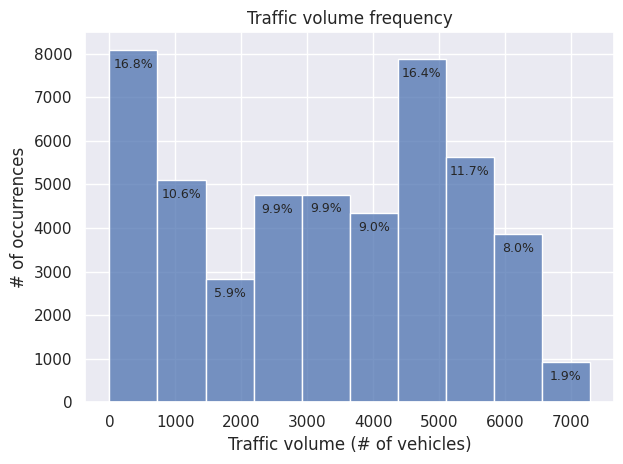

In [8]:
volume_frequency = sns.histplot(
    data=traffic_volume_database,
    x='traffic_volume',
    bins=10
)

for p in volume_frequency.patches:
    height = p.get_height()
    total = len(traffic_volume_database)
    percentage = height / total * 100
    volume_frequency.text(
        p.get_x() + p.get_width() / 2,
        height - total * 0.01,
        f"{percentage:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title("Traffic volume frequency")
plt.xlabel("Traffic volume (# of vehicles)")
plt.ylabel("# of occurrences")
plt.tight_layout()
plt.show()

plt.show()

Then looking at
### 2.2 Daytime & type of the day (weekday vs weekends, holidays) correlation

Starting with visualising how traffic looks like on various week days and hours:

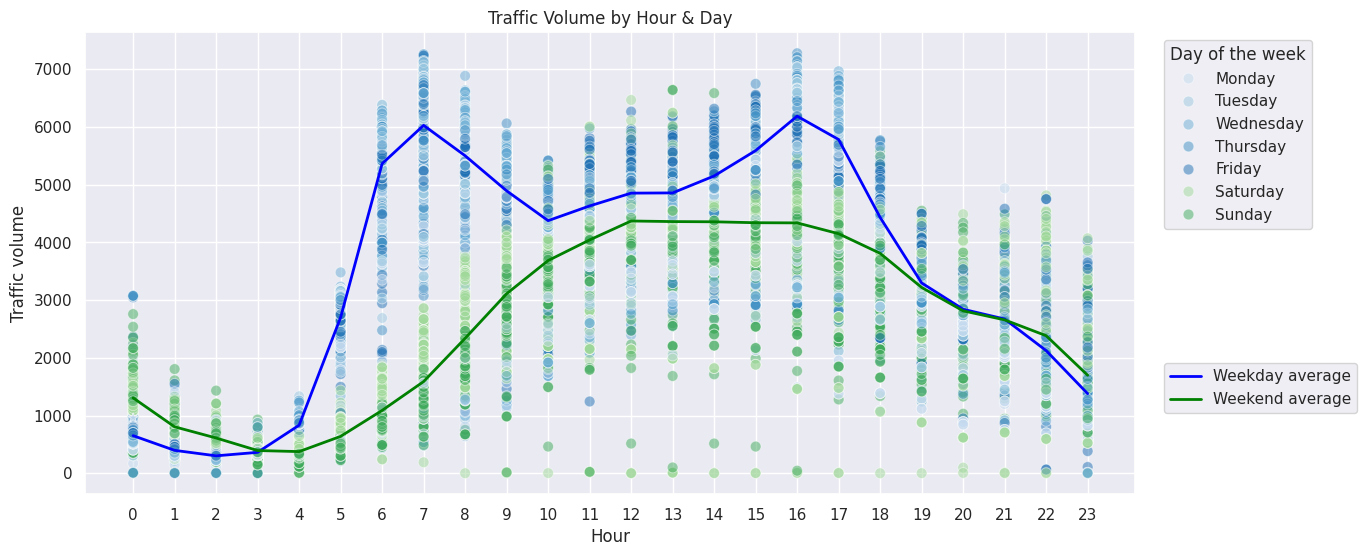

In [20]:
# changing if_holidays and day_of the week variables naming to avoid confusion while mapping the key
dow_map = { 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday' }
traffic_volume_database['dow_label'] = traffic_volume_database['day_of_the_week'].map(dow_map)

# defining colours to distinguish day of the week
day_of_the_week_color_palette = {
    'Monday': '#c6dbef', 'Tuesday': '#9ecae1', 'Wednesday': '#6baed6', 'Thursday': '#4292c6', 'Friday': '#2171b5', # = blue tones
    'Saturday': '#a1d99b', 'Sunday': '#41ab5d' # = green tones
}

# placing data points on the graph
plt.figure(figsize=(12, 6))
plot = sns.scatterplot(
    data=traffic_volume_database,
    x='hour',
    y='traffic_volume',
    hue='dow_label',
    style='holiday_label',
    palette=day_of_the_week_color_palette,
    markers={'Not': 'o', 'Holiday': '*'},
    alpha=0.5,
    #edgecolor='black',
    s=60
)

'''
# creating trend line for weekndays vs weekends
workdays = traffic_volume_database[traffic_volume_database['day_of_the_week'] < 5]
weekends = traffic_volume_database[traffic_volume_database['day_of_the_week'] >= 5]

sns.regplot(
    data=workdays,
    x='hour',
    y='traffic_volume',
    scatter=False,
    color='blue',
    line_kws={'linewidth': 2, 'label': 'Weekday trend'}
)
sns.regplot(
    data=weekends,
    x='hour',
    y='traffic_volume',
    scatter=False,
    color='green',
    line_kws={'linewidth': 2, 'label': 'Weekend trend'}
)
'''

#creating averages tracking
avg_by_hour = traffic_volume_database.groupby(['hour', 'if_weekend'])['traffic_volume'].mean().reset_index()
weekday_avg = avg_by_hour[avg_by_hour['if_weekend'] == 0]
weekend_avg = avg_by_hour[avg_by_hour['if_weekend'] == 1]

from matplotlib.lines import Line2D
avg_handles = [
    Line2D([0], [0], color='blue', linewidth=2, label='Weekday average'),
    Line2D([0], [0], color='green', linewidth=2, label='Weekend average')
]

plt.plot(
    weekday_avg['hour'],
    weekday_avg['traffic_volume'],
    color='blue',
    linewidth=2,
    label='Weekday average'
)
plt.plot(
    weekend_avg['hour'],
    weekend_avg['traffic_volume'],
    color='green',
    linewidth=2,
    label='Weekend average'
)



# adjusting the key description
handles, labels = plot.get_legend_handles_labels()
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holiday_labels = ['Not', 'Holiday']
holiday_order = ['Not', 'Holiday']
label_to_handle = dict(zip(labels, handles))
day_handles = [label_to_handle[d] for d in day_order]
holiday_handles = [label_to_handle[h] for h in holiday_order]
legend1 = plt.legend(
    day_handles, day_labels,
    title='Day of the week',
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(legend1) # <- so both legend appear
plt.legend(
    handles=avg_handles,
    title='',
    loc='upper left',
    bbox_to_anchor=(1.02, 0.3)
)
plt.subplots_adjust(right=1)

#presenting the graph
plt.title("Traffic Volume by Hour & Day")
plt.xlabel("Hour")
plt.ylabel("Traffic volume")
plt.xticks(range(0, 24))
plt.show()


Adding Holidays as well:

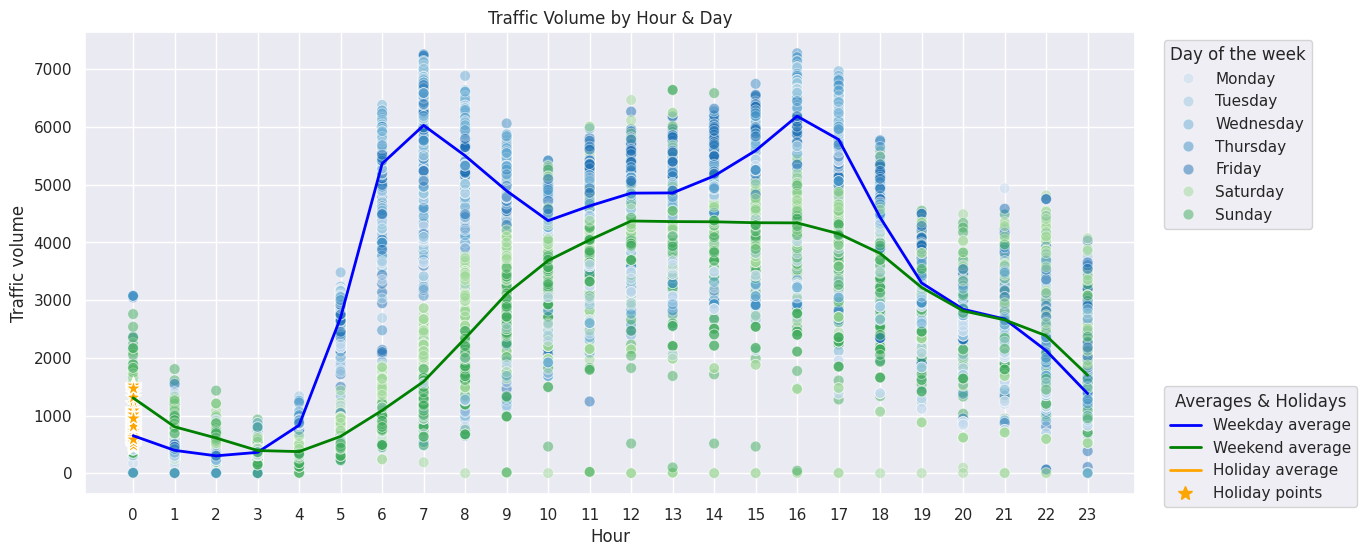

In [21]:
# changing if_holidays and day_of the week variables naming to avoid confusion while mapping the key
holiday_map = {0: 'Not', 1: 'Holiday'}
traffic_volume_database['holiday_label'] = traffic_volume_database['if_holiday'].map(holiday_map)

dow_map = { 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday' }
traffic_volume_database['dow_label'] = traffic_volume_database['day_of_the_week'].map(dow_map)

# defining colours to distinguish day of the week
day_of_the_week_color_palette = {
    'Monday': '#c6dbef', 'Tuesday': '#9ecae1', 'Wednesday': '#6baed6', 'Thursday': '#4292c6', 'Friday': '#2171b5', # = blue tones
    'Saturday': '#a1d99b', 'Sunday': '#41ab5d' # = green tones
}

# placing data points on the graph
plt.figure(figsize=(12, 6))
plot = sns.scatterplot(
    data=traffic_volume_database,
    x='hour',
    y='traffic_volume',
    hue='dow_label',
    style='holiday_label',
    palette=day_of_the_week_color_palette,
    markers={'Not': 'o', 'Holiday': '*'},
    alpha=0.5,
    #edgecolor='black',
    s=60
)
sns.scatterplot(
    data=traffic_volume_database[traffic_volume_database['if_holiday'] == 1],
    x='hour',
    y='traffic_volume',
    marker='*',
    color='orange',
    s=150,
    label='Holiday'
)

#creating averages tracking
avg_by_hour = traffic_volume_database.groupby(['hour', 'if_weekend'])['traffic_volume'].mean().reset_index()
weekday_avg = avg_by_hour[avg_by_hour['if_weekend'] == 0]
weekend_avg = avg_by_hour[avg_by_hour['if_weekend'] == 1]
holiday_avg = traffic_volume_database[traffic_volume_database['if_holiday'] == 1].groupby('hour')['traffic_volume'].mean().reset_index()

from matplotlib.lines import Line2D
avg_handles = [
    Line2D([0], [0], color='blue', linewidth=2, label='Weekday average'),
    Line2D([0], [0], color='green', linewidth=2, label='Weekend average'),
    Line2D([0], [0], color='orange', linewidth=2, label='Holiday average'),
    Line2D([0], [0], marker='*', color='orange', linestyle='None', markersize=10, label='Holiday points')
]

plt.plot(
    weekday_avg['hour'],
    weekday_avg['traffic_volume'],
    color='blue',
    linewidth=2,
    label='Weekday average'
)
plt.plot(
    weekend_avg['hour'],
    weekend_avg['traffic_volume'],
    color='green',
    linewidth=2,
    label='Weekend average'
)
plt.plot(
    holiday_avg['hour'],
    holiday_avg['traffic_volume'],
    color='orange',
    linewidth=2,
    label='Holiday average'
)



# adjusting the key description
handles, labels = plot.get_legend_handles_labels()
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holiday_labels = ['Not', 'Holiday']
holiday_order = ['Not', 'Holiday']
label_to_handle = dict(zip(labels, handles))
day_handles = [label_to_handle[d] for d in day_order]
holiday_handles = [label_to_handle[h] for h in holiday_order]
legend1 = plt.legend(
    day_handles, day_labels,
    title='Day of the week',
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)
plt.gca().add_artist(legend1) # <- so both legend appear
plt.legend(
    handles=avg_handles,
    title='Averages & Holidays',
    loc='upper left',
    bbox_to_anchor=(1.02, 0.25)
)
plt.subplots_adjust(right=1)

#presenting the graph
plt.title("Traffic Volume by Hour & Day")
plt.xlabel("Hour")
plt.ylabel("Traffic volume")
plt.xticks(range(0, 24))
plt.show()


And then formalizing it with numbers assesing real correlation size

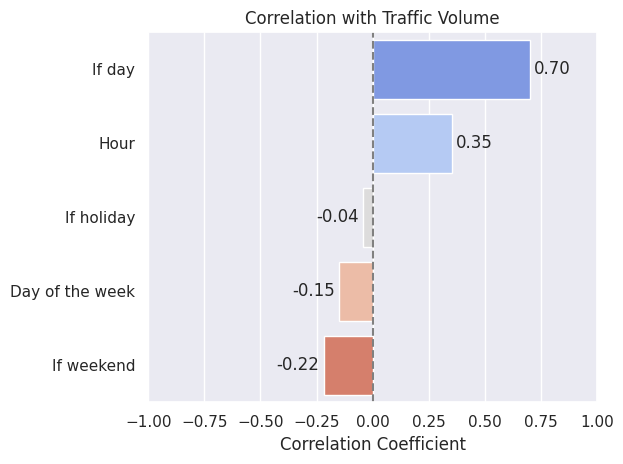

In [22]:
correlations_with = ['hour', 'if_day', 'day_of_the_week', 'if_weekend', 'if_holiday']
correlations = traffic_volume_database[correlations_with + ['traffic_volume']].corr()

traffic_correlations = correlations['traffic_volume'].drop('traffic_volume').sort_values(ascending=False)
#print(traffic_correlations)
corr_df = traffic_correlations.reset_index()
corr_df.columns = ['variable', 'correlation']
corr_df['label'] = corr_df['variable'].str.replace('_', ' ').str.capitalize()
ax = sns.barplot(data=corr_df, x='correlation', y='label', hue='label', palette='coolwarm', dodge=False, legend=False )
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)
    
plt.title('Correlation with Traffic Volume')
plt.xlabel('Correlation Coefficient')
plt.ylabel('')
plt.xlim(-1, 1)
plt.axvline(0, color='gray', linestyle='--')  # linia zerowa dla kontekstu
plt.tight_layout()
plt.show()

### 2.3 Weather correlations

Starting with visual representation of main weather and temprature impact:

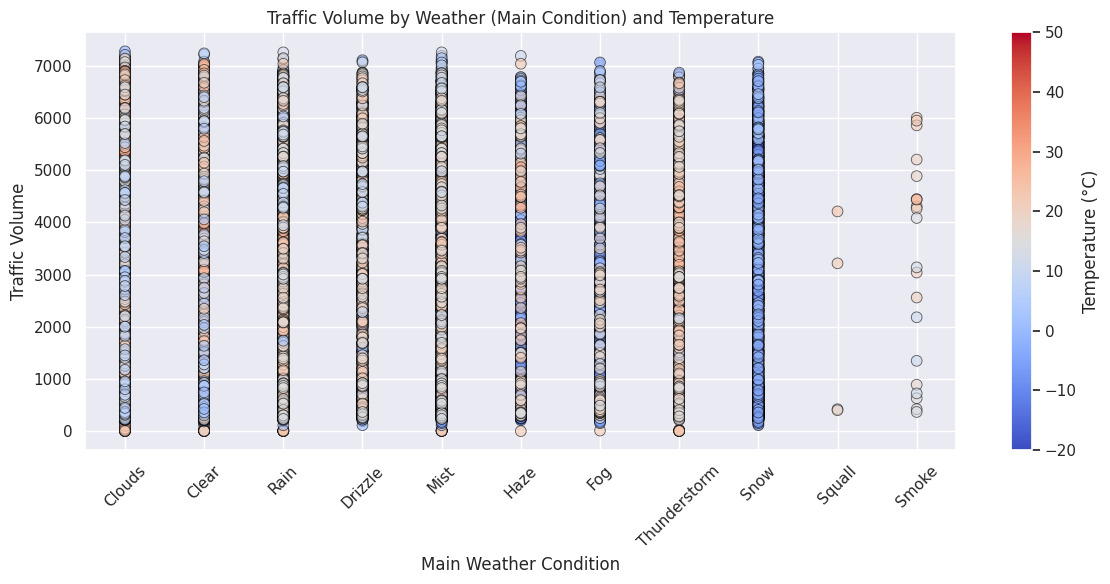

In [23]:
# normalizing temprature
traffic_volume_database['temp_celsius'] = traffic_volume_database['temp'] - 273.15
q_low = traffic_volume_database['temp_celsius'].quantile(0.01)
q_high = traffic_volume_database['temp_celsius'].quantile(0.99)
temp_celsius = traffic_volume_database[
    (traffic_volume_database['temp_celsius'] >= q_low) &
    (traffic_volume_database['temp_celsius'] <= q_high)
].copy()
from matplotlib.colors import Normalize
norm = Normalize(vmin=-20, vmax=50)

# then creating the graph
fig, ax = plt.subplots(figsize=(12, 6))
plot1 = sns.scatterplot(
    data=temp_celsius,
    x='weather_main',
    y='traffic_volume',
    hue='temp_celsius',
    palette='coolwarm',
    hue_norm=norm,
    alpha=0.6,
    edgecolor='black',
    s=60,
    ax=ax,
    legend=False
)

# and its description
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Temperature (°C)')

plt.title("Traffic Volume by Weather (Main Condition) and Temperature")
plt.xlabel("Main Weather Condition")
plt.ylabel("Traffic Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To quickly dive deeper into those variables in seperation:

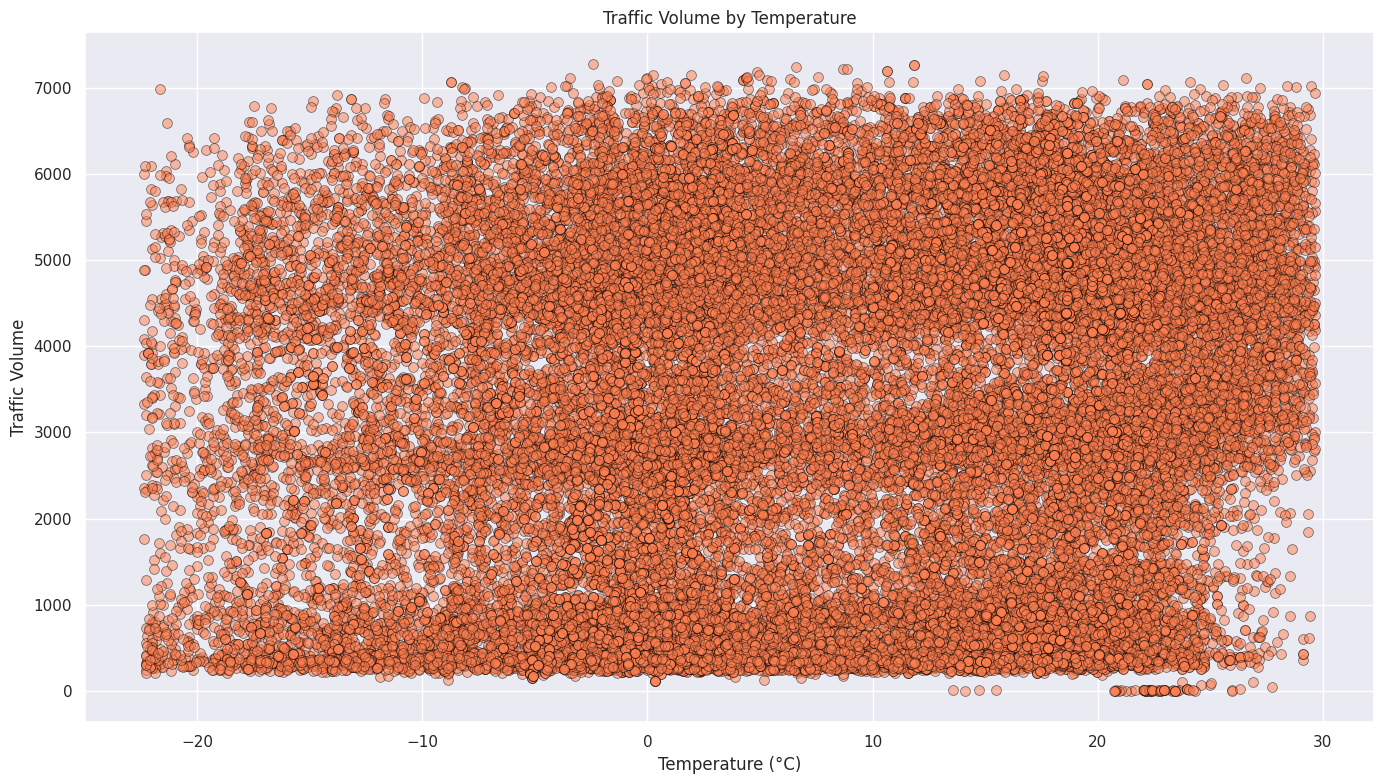

In [24]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=temp_celsius,
    x='temp_celsius',
    y='traffic_volume',
    color='coral',
    alpha=0.5,
    edgecolor='black',
    s=50
)

plt.title("Traffic Volume by Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Traffic Volume")
plt.tight_layout()
plt.show()


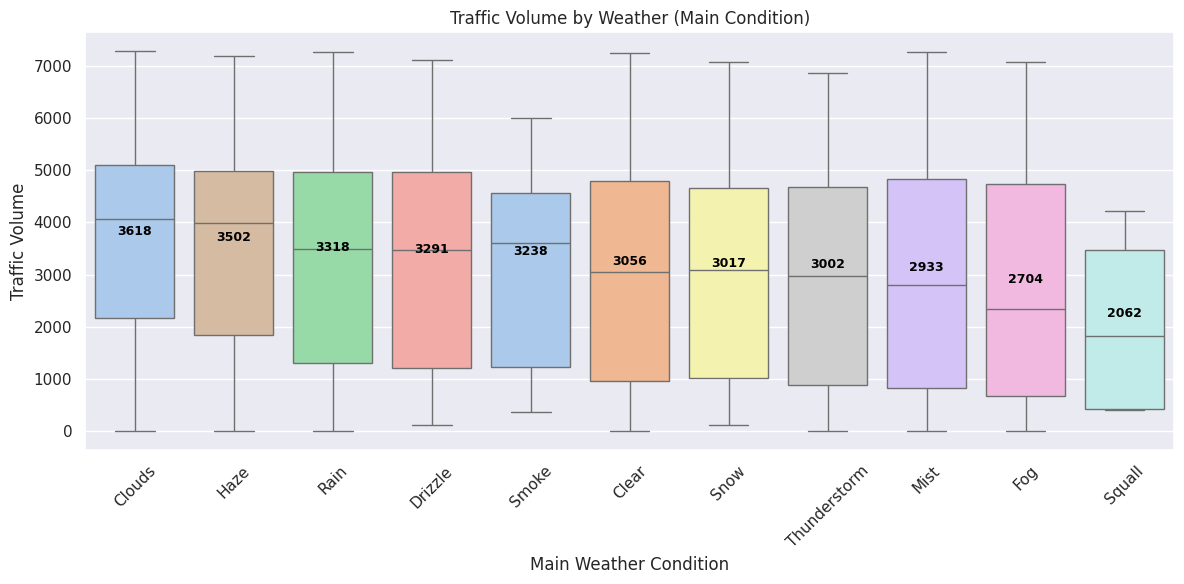

In [25]:
mean_traffic = traffic_volume_database.groupby('weather_main')['traffic_volume'].mean().sort_values(ascending=False)
ordered_weather = mean_traffic.index.tolist()

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=traffic_volume_database,
    x='weather_main',
    y='traffic_volume',
    order=ordered_weather,
    palette='pastel',
    hue='weather_main',
    legend=False
)

for i, category in enumerate(ordered_weather):
    mean_val = mean_traffic[category]
    ax.text(i, mean_val + 200, f"{mean_val:.0f}",
            ha='center', va='center', fontsize=9, fontweight='bold', color='black')

plt.title("Traffic Volume by Weather (Main Condition)")
plt.xlabel("Main Weather Condition")
plt.ylabel("Traffic Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's also take a look at more detailed weather descriptions added to the database:

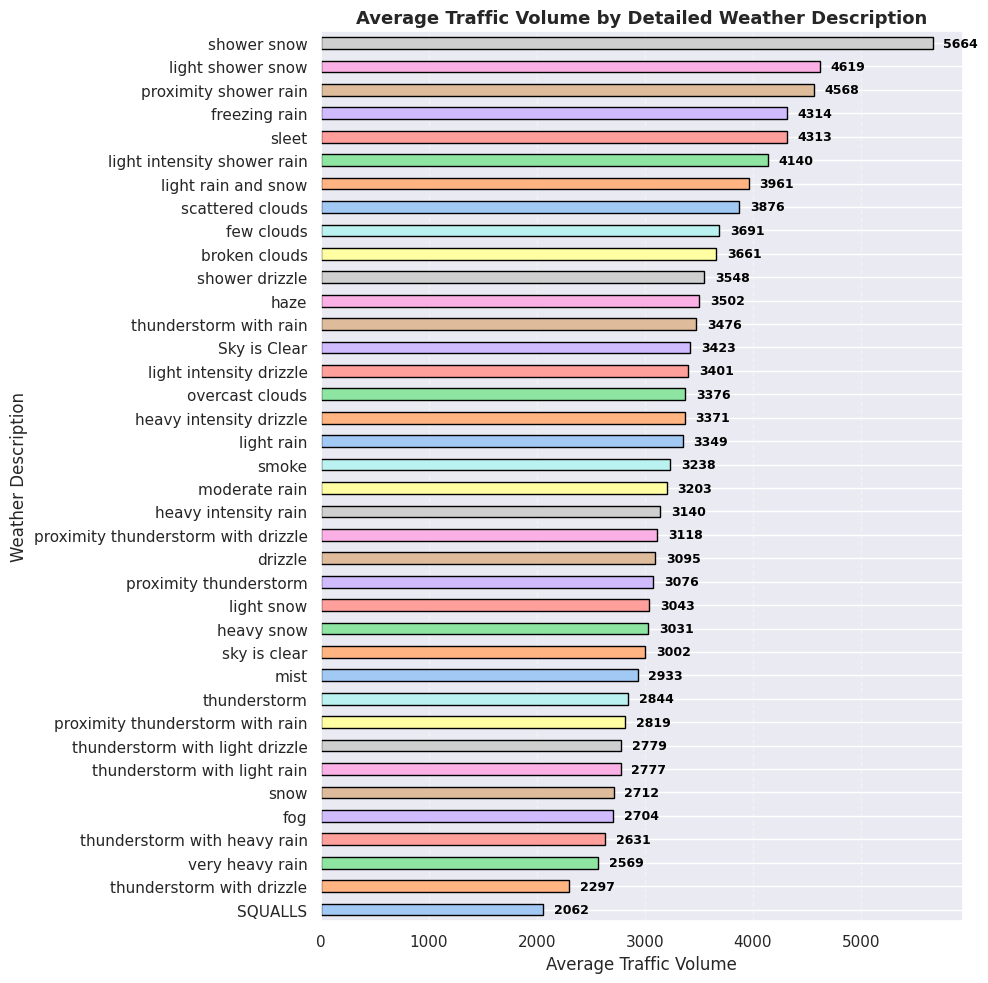

In [26]:
by_weather_description = traffic_volume_database.groupby('weather_description')['traffic_volume'].mean().sort_values()

plt.figure(figsize=(10, 10))
ax = by_weather_description.plot.barh(
    color=sns.color_palette('pastel', n_colors=len(by_weather_description)),
    edgecolor='black'
)

for i, (desc, val) in enumerate(by_weather_description.items()):
    ax.text(val + 100, i, f"{val:.0f}", va='center', fontsize=9, fontweight='bold', color='black')

plt.title("Average Traffic Volume by Detailed Weather Description", fontsize=13, fontweight='bold')
plt.xlabel("Average Traffic Volume")
plt.ylabel("Weather Description")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


And precipitation quantity:

In [ ]:
'''# defining dominant precipitation

rain_q25 = traffic_volume_database['rain_1h'].quantile(0.25)
snow_q25 = traffic_volume_database['snow_1h'].quantile(0.25)
clouds_q25 = traffic_volume_database['clouds_all'].quantile(0.25)

def dominant_weather(row):
    r, s, c = row['rain_1h'], row['snow_1h'], row['clouds_all']
    
    # Jeśli wszystko niskie – neutralny kształt
    if r <= rain_q25 and s <= snow_q25 and c <= clouds_q25:
        return 'Clear'

    # Zjawisko dominujące
    dominant = max([(r, 'Rain'), (s, 'Snow'), (c, 'Cloud')], key=lambda x: x[0])[1]
    return dominant

traffic_volume_database['weather_shape'] = traffic_volume_database.apply(dominant_weather, axis=1)

weather_shape_markers = {
    'Clear': 'o',      
    'Rain': 'v',       
    'Snow': '*',       
    'Cloud': 's'       
}'''

# removing outliers  
rain_cap = traffic_volume_database['rain_1h'].quantile(0.99)
snow_cap = traffic_volume_database['snow_1h'].quantile(0.99)
clouds_cap = traffic_volume_database['clouds_all'].quantile(0.99)

filtered_df = traffic_volume_database[
    (traffic_volume_database['rain_1h'] <= rain_cap) &
    (traffic_volume_database['snow_1h'] <= snow_cap) &
    (traffic_volume_database['clouds_all'] <= clouds_cap)
].copy()

# normalizing precipitation data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
filtered_df[['rain_norm', 'snow_norm', 'clouds_norm']] = scaler.fit_transform(filtered_df[['rain_1h', 'snow_1h', 'clouds_all']])


# creating graph
plt.figure(figsize=(14, 6))

sns.scatterplot(
    data=filtered_df,
    x='rain_norm',
    y='traffic_volume',
    marker='v',
    color='blue',
    alpha=0.5,
    edgecolor='black',
    s=60,
    label='Rain'
)

sns.scatterplot(
    data=filtered_df,
    x='snow_norm',
    y='traffic_volume',
    marker='*',
    color='skyblue',
    alpha=0.5,
    edgecolor='black',
    s=80,
    label='Snow'
)

sns.scatterplot(
    data=filtered_df,
    x='clouds_norm',
    y='traffic_volume',
    marker='s',
    color='gray',
    alpha=0.5,
    #edgecolor='black',
    s=60,
    label='Clouds'
)

# adding trend lines
sns.regplot(
    data=filtered_df,
    x='rain_norm',
    y='traffic_volume',
    scatter=False,
    color='blue',
    label='Rain trend',
    line_kws={'linewidth': 2}
)
sns.regplot(
    data=filtered_df,
    x='snow_norm',
    y='traffic_volume',
    scatter=False,
    color='skyblue',
    label='Snow trend',
    line_kws={'linewidth': 2}
)
sns.regplot(
    data=filtered_df,
    x='clouds_norm',
    y='traffic_volume',
    scatter=False,
    color='gray',
    label='Clouds trend',
    line_kws={'linewidth': 2}
)


# describing graph
plt.title("Traffic Volume by Normalized Precipitation & Cloud Coverage")
plt.xlabel("Normalized Precipitation / Cloudiness")
plt.ylabel("Traffic Volume")
plt.legend(
    title="Variable",
    bbox_to_anchor=(1.02, 1),  # <-- na prawo od wykresu
    loc='upper left',
    borderaxespad=0
)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()

To colclude with formal correlation checking:

In [ ]:
weather_vars = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main_code', 'weather_description_code']

# Korelacja z traffic_volume
correlations = traffic_volume_database[weather_vars + ['traffic_volume']].corr()

# Wyciągamy tylko korelacje z traffic_volume (i bez self-korelacji)
weather_correlations = correlations['traffic_volume'].drop('traffic_volume').sort_values(ascending=False)

# Do DataFrame do wykresu
corr_df = weather_correlations.reset_index()
corr_df.columns = ['variable', 'correlation']
corr_df['label'] = corr_df['variable'].str.replace('_', ' ').str.capitalize()


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=corr_df,
    x='correlation',
    y='label',
    hue='label',
    palette='coolwarm',
    dodge=False,
    legend=False
)

# Dodaj wartości korelacji jako etykiety
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.title('Correlation with Traffic Volume (Weather Variables)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('')
plt.xlim(-1, 1)
plt.axvline(0, color='gray', linestyle='--')  # linia 0 dla odniesienia
plt.tight_layout()
plt.show()


## 3. Conclusion

### Correlation with Time & Day

**The time of day is the most strongly correlated factor with traffic volume**, with a correlation coefficient of approximately **r = 0.7**, indicating a strong relationship.

- Traffic is significantly lower during the night (between midnight and 5 AM).
- Peak hours on weekdays occur around **7 AM** and **4 PM**.

The **negative correlation of -0.22 for weekends** suggests that people tend to travel less on weekends.

- This effect is most noticeable during the **morning hours (6–10 AM)**, when the difference between weekday and weekend traffic is the largest.
- Although the gap persists until around **6 PM**, it becomes less pronounced throughout the day.
- Interestingly, **nighttime traffic is slightly higher on weekends** compared to weekdays.


### Influence of Weather

Weather-related factors show **much weaker correlations** with traffic volume.

**Temperature** displays a modest positive correlation of **r = 0.13** with traffic volume.
- This indicates that we tend to travel **slightly less when it’s very cold**, likely because people avoid going outside.
- Conversely, **traffic volume increases in very warm weather** — possibly because people spend more time outdoors but prefer to commute in air-conditioned vehicles.


There also appears to be a **slight drop in traffic during foggy or misty conditions** (e.g., *mist*, *drizzle*, *fog*).  
**Thunderstorms** and **snow** also discourage travel, while **regular rain** or **cloudy conditions** seem to have a **less significant impact** on traffic behavior.

